In [ ]:
import pandas as pd
import tensorflow_datasets as tfds
from tqdm import tqdm

# Adathalmaz letöltése
dataset_train = tfds.load('imdb_reviews', split='train', shuffle_files=True)
dataset_test = tfds.load('imdb_reviews', split='test', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCVKSJN/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCVKSJN/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCVKSJN/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def convert_to_df(dataset):
    data = [{ 'text': item['text'].numpy().decode('utf-8'), 'label': item['label'].numpy() } for item in tqdm(dataset)]
    return pd.DataFrame(data)

df_train = convert_to_df(dataset_train)
df_test = convert_to_df(dataset_test)

100%|██████████| 25000/25000 [00:08<00:00, 2849.04it/s]


array([[<Axes: title={'center': 'label'}>]], dtype=object)

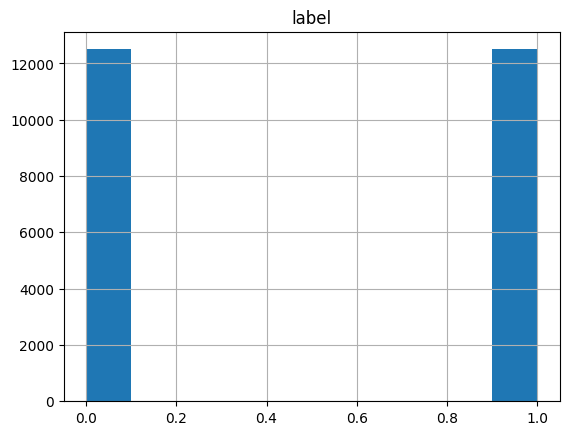

In [ ]:
df_train.hist()

array([[<Axes: title={'center': 'label'}>]], dtype=object)

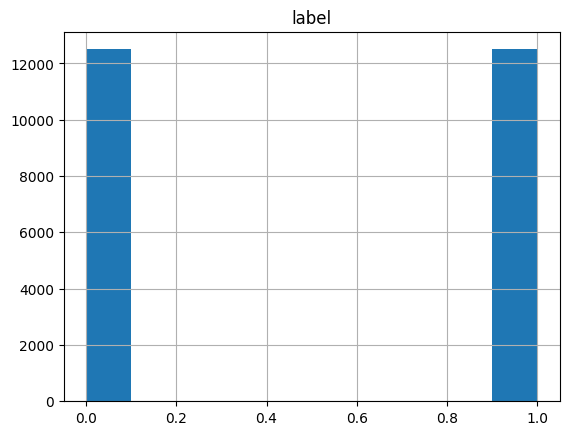

In [ ]:
df_test.hist()

In [ ]:
def sentiment(value):
    if(value == 1):
        return "positive"
    else:
        return "negative"

df_train["sentiment"] = [None] * len(df_train)
df_train["sentiment"] = df_train["label"].apply(sentiment)
df_test["sentiment"] = [None] * len(df_test)
df_test["sentiment"] = df_test["label"].apply(sentiment)

df_train.head()

,text,label,sentiment
0,This was an absolutely terrible movie. Don't b...,0,negative
1,"I have been known to fall asleep during films,...",0,negative
2,Mann photographs the Alberta Rocky Mountains i...,0,negative
3,This is the kind of film for a snowy Sunday af...,1,positive
4,"As others have mentioned, all the women that g...",1,positive


In [ ]:
#adattisztítás
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')

STOPWORDS = stopwords.words("english")

STOPWORDS[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
from bs4 import BeautifulSoup

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    
    return text

In [ ]:
df_train["text"] = df_train["text"].apply(remove_html_tags)

<ipython-input-7-37b9271831de>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
nltk.download('punkt')

tokenized_reviews = df_train["text"].apply(lambda review_text: word_tokenize(review_text.replace("\n","").lower()))

tokenized_reviews.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0    [this, was, an, absolutely, terrible, movie, ....
1    [i, have, been, known, to, fall, asleep, durin...
2    [mann, photographs, the, alberta, rocky, mount...
3    [this, is, the, kind, of, film, for, a, snowy,...
4    [as, others, have, mentioned, ,, all, the, wom...
Name: text, dtype: object

In [ ]:
d = dict()

for review in tqdm(tokenized_reviews):
    for word in review:
        if word not in STOPWORDS and word.isalpha():
            d[word] = d.get(word, 0) + 1

100%|██████████| 25000/25000 [00:14<00:00, 1719.93it/s]


In [ ]:
d = sorted(d.items(), key=lambda item: item[1], reverse=True)
d[:10]

[('movie', 42587),
 ('film', 38764),
 ('one', 25574),
 ('like', 19664),
 ('good', 14612),
 ('would', 13378),
 ('even', 12452),
 ('time', 11904),
 ('really', 11682),
 ('story', 11559)]

In [ ]:
DESIRED_VOCAB_SIZE = 4000

VOCAB = [k for k,v in d[:DESIRED_VOCAB_SIZE]]
word_table = pd.DataFrame({"word": VOCAB})
word_table.head(10)

,word
0,movie
1,film
2,one
3,like
4,good
5,would
6,even
7,time
8,really
9,story


In [ ]:
dict_freqs = {"positive": {}, "negative": {}}

In [ ]:
#naiv Bayes
VOCAB_IDX = {}
for i in range(0, len(word_table["word"].values)):
  VOCAB_IDX[word_table["word"].values[i]] = i

for idx in range(df_train.shape[0]):
  review = df_train.iloc[idx]["text"]
  sentiment = df_train.iloc[idx]["sentiment"]

  for word in review.split(" "):
    if word in VOCAB_IDX:
      dict_freqs[sentiment][word] = dict_freqs[sentiment].get(word, 0) + 1

In [ ]:
print("story idx:", VOCAB_IDX["story"])

story idx: 9


In [ ]:
print("positive good", dict_freqs["positive"]["good"])
print("negative good", dict_freqs["negative"]["good"])

positive good 5794
negative good 5642


In [ ]:
total_positive = sum(dict_freqs["negative"].values())

word_table["negative"] = [(dict_freqs["negative"].get(w, 0)+1) / (total_positive + len(VOCAB)) for w in word_table["word"]]

In [ ]:
total_positive = sum(dict_freqs["positive"].values())

word_table["positive"] = [(dict_freqs["positive"].get(w, 0)+1) / (total_positive + len(VOCAB)) for w in word_table["word"]]

In [ ]:
word_table.head()

,word,negative,positive
0,movie,0.020738,0.016128
1,film,0.015720,0.017386
2,one,0.012113,0.012888
3,like,0.012293,0.009624
4,good,0.006830,0.006990


In [ ]:
import numpy as np

word_table["ratio"] = np.log(word_table["positive"] / word_table["negative"])
word_table = word_table.set_index("word")

word_table

,negative,positive,ratio
word,,,
movie,0.020738,0.016128,-0.251414
film,0.015720,0.017386,0.100755
one,0.012113,0.012888,0.062060
like,0.012293,0.009624,-0.244747
good,0.006830,0.006990,0.023084
...,...,...,...
griffith,0.000001,0.000002,0.689652
illogical,0.000067,0.000023,-1.066390
goodness,0.000046,0.000035,-0.273786


In [ ]:
word_table["ratio"].describe()

count    4000.000000
mean        0.030011
std         0.598702
min        -2.753095
25%        -0.258304
50%         0.032547
75%         0.385674
max         2.508810
Name: ratio, dtype: float64

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

STOPWORDS = stopwords.words("english")

def predict_for_review_raw(review):
  _input = remove_html_tags(review)
  _input = word_tokenize(_input.lower())

  word_table_words = word_table.index
  return sum([word_table["ratio"].loc[token] for token in _input if token in word_table_words])

In [ ]:
predict_for_review_raw("This movie sucks.")

-1.7212466428952966

In [ ]:
predict_for_review_raw("This movie was fantastic!")

1.2106579679125289

In [ ]:
def predict_for_review(review):
  return int(predict_for_review_raw(review) > 0)

In [ ]:
preds = df_train["text"].apply(predict_for_review)

<ipython-input-7-37b9271831de>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
def get_accurary(preds, real):
  return sum(preds == real) / len(real)

In [ ]:
real = (df_train["sentiment"] == "positive").astype(int)
print(f"Training set accuracy: {get_accurary(preds, real)}")

Training set accuracy: 0.85396


In [ ]:
preds_test = df_test["text"].apply(predict_for_review)
real_test = (df_test["sentiment"] == "positive").astype(int)
print(f"Test set accuracy: {get_accurary(preds_test, real_test)}")

<ipython-input-7-37b9271831de>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


Test set accuracy: 0.8418
